In [1]:
!pip install -q -U openai langchain-openai anthropic docling easyocr 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/113.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 74.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -q opencv-python supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.1 MB/s eta 0:00:00


### PARSE PDF

In [3]:
import logging
import time
from pathlib import Path
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem
from docling.datamodel.base_models import FigureElement, InputFormat, Table
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
_log = logging.getLogger(__name__)
IMAGE_RESOLUTION_SCALE = 5.0
logging.basicConfig(level=logging.INFO)

input_doc_path = Path("/kaggle/input/plumbing/RedHead Rooter Service Call Tree.pdf")
output_dir = Path("imgs")

pipeline_options = PdfPipelineOptions()
pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True

doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

start_time = time.time()

conv_res = doc_converter.convert(input_doc_path)

output_dir.mkdir(parents=True, exist_ok=True)
doc_filename = conv_res.input.file.stem

# Save page images
for page_no, page in conv_res.document.pages.items():
    page_no = page.page_no
    page_image_filename = output_dir / f"{doc_filename}-{page_no}.jpeg"
    with page_image_filename.open("wb") as fp:
        page.image.pil_image.save(fp, format="JPEG")

# Save images of figures and tables
table_counter = 0
picture_counter = 0
for element, _level in conv_res.document.iterate_items():
    if isinstance(element, TableItem):
        table_counter += 1
        element_image_filename = (
            output_dir / f"{doc_filename}-table-{table_counter}.jpeg"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "JPEG")

    if isinstance(element, PictureItem):
        picture_counter += 1
        element_image_filename = (
            output_dir / f"{doc_filename}-picture-{picture_counter}.jpeg"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "JPEG")

end_time = time.time() - start_time

_log.info(f"Document converted and figures exported in {end_time:.2f} seconds.")

### GET NODES FOR VISUALIZATION

In [4]:
# RUN THIS JUST TO GET DATA TO SHOW ON IMAGE
import easyocr
reader = easyocr.Reader(['ch_sim','en'], )
verbose_nodes = reader.readtext('/kaggle/working/imgs/RedHead Rooter Service Call Tree-1.jpeg',
                        detail = 1, paragraph=False,
                        canvas_size=5000,
                        decoder="wordbeamsearch",
                        ## experiment below. Ref: https://www.jaided.ai/easyocr/documentation/
                        beamWidth = 10,
                        width_ths=0.9, 
                        # height_ths=1.2,
                        text_threshold=0.6,
                        # x_ths=1,
                        # y_ths=1.9,
                        # ycenter_ths=0.7,
                        # mag_ratio=1.5,
                        )

Progress: |██████████████████████████████████████████████████| 100.0% Complete

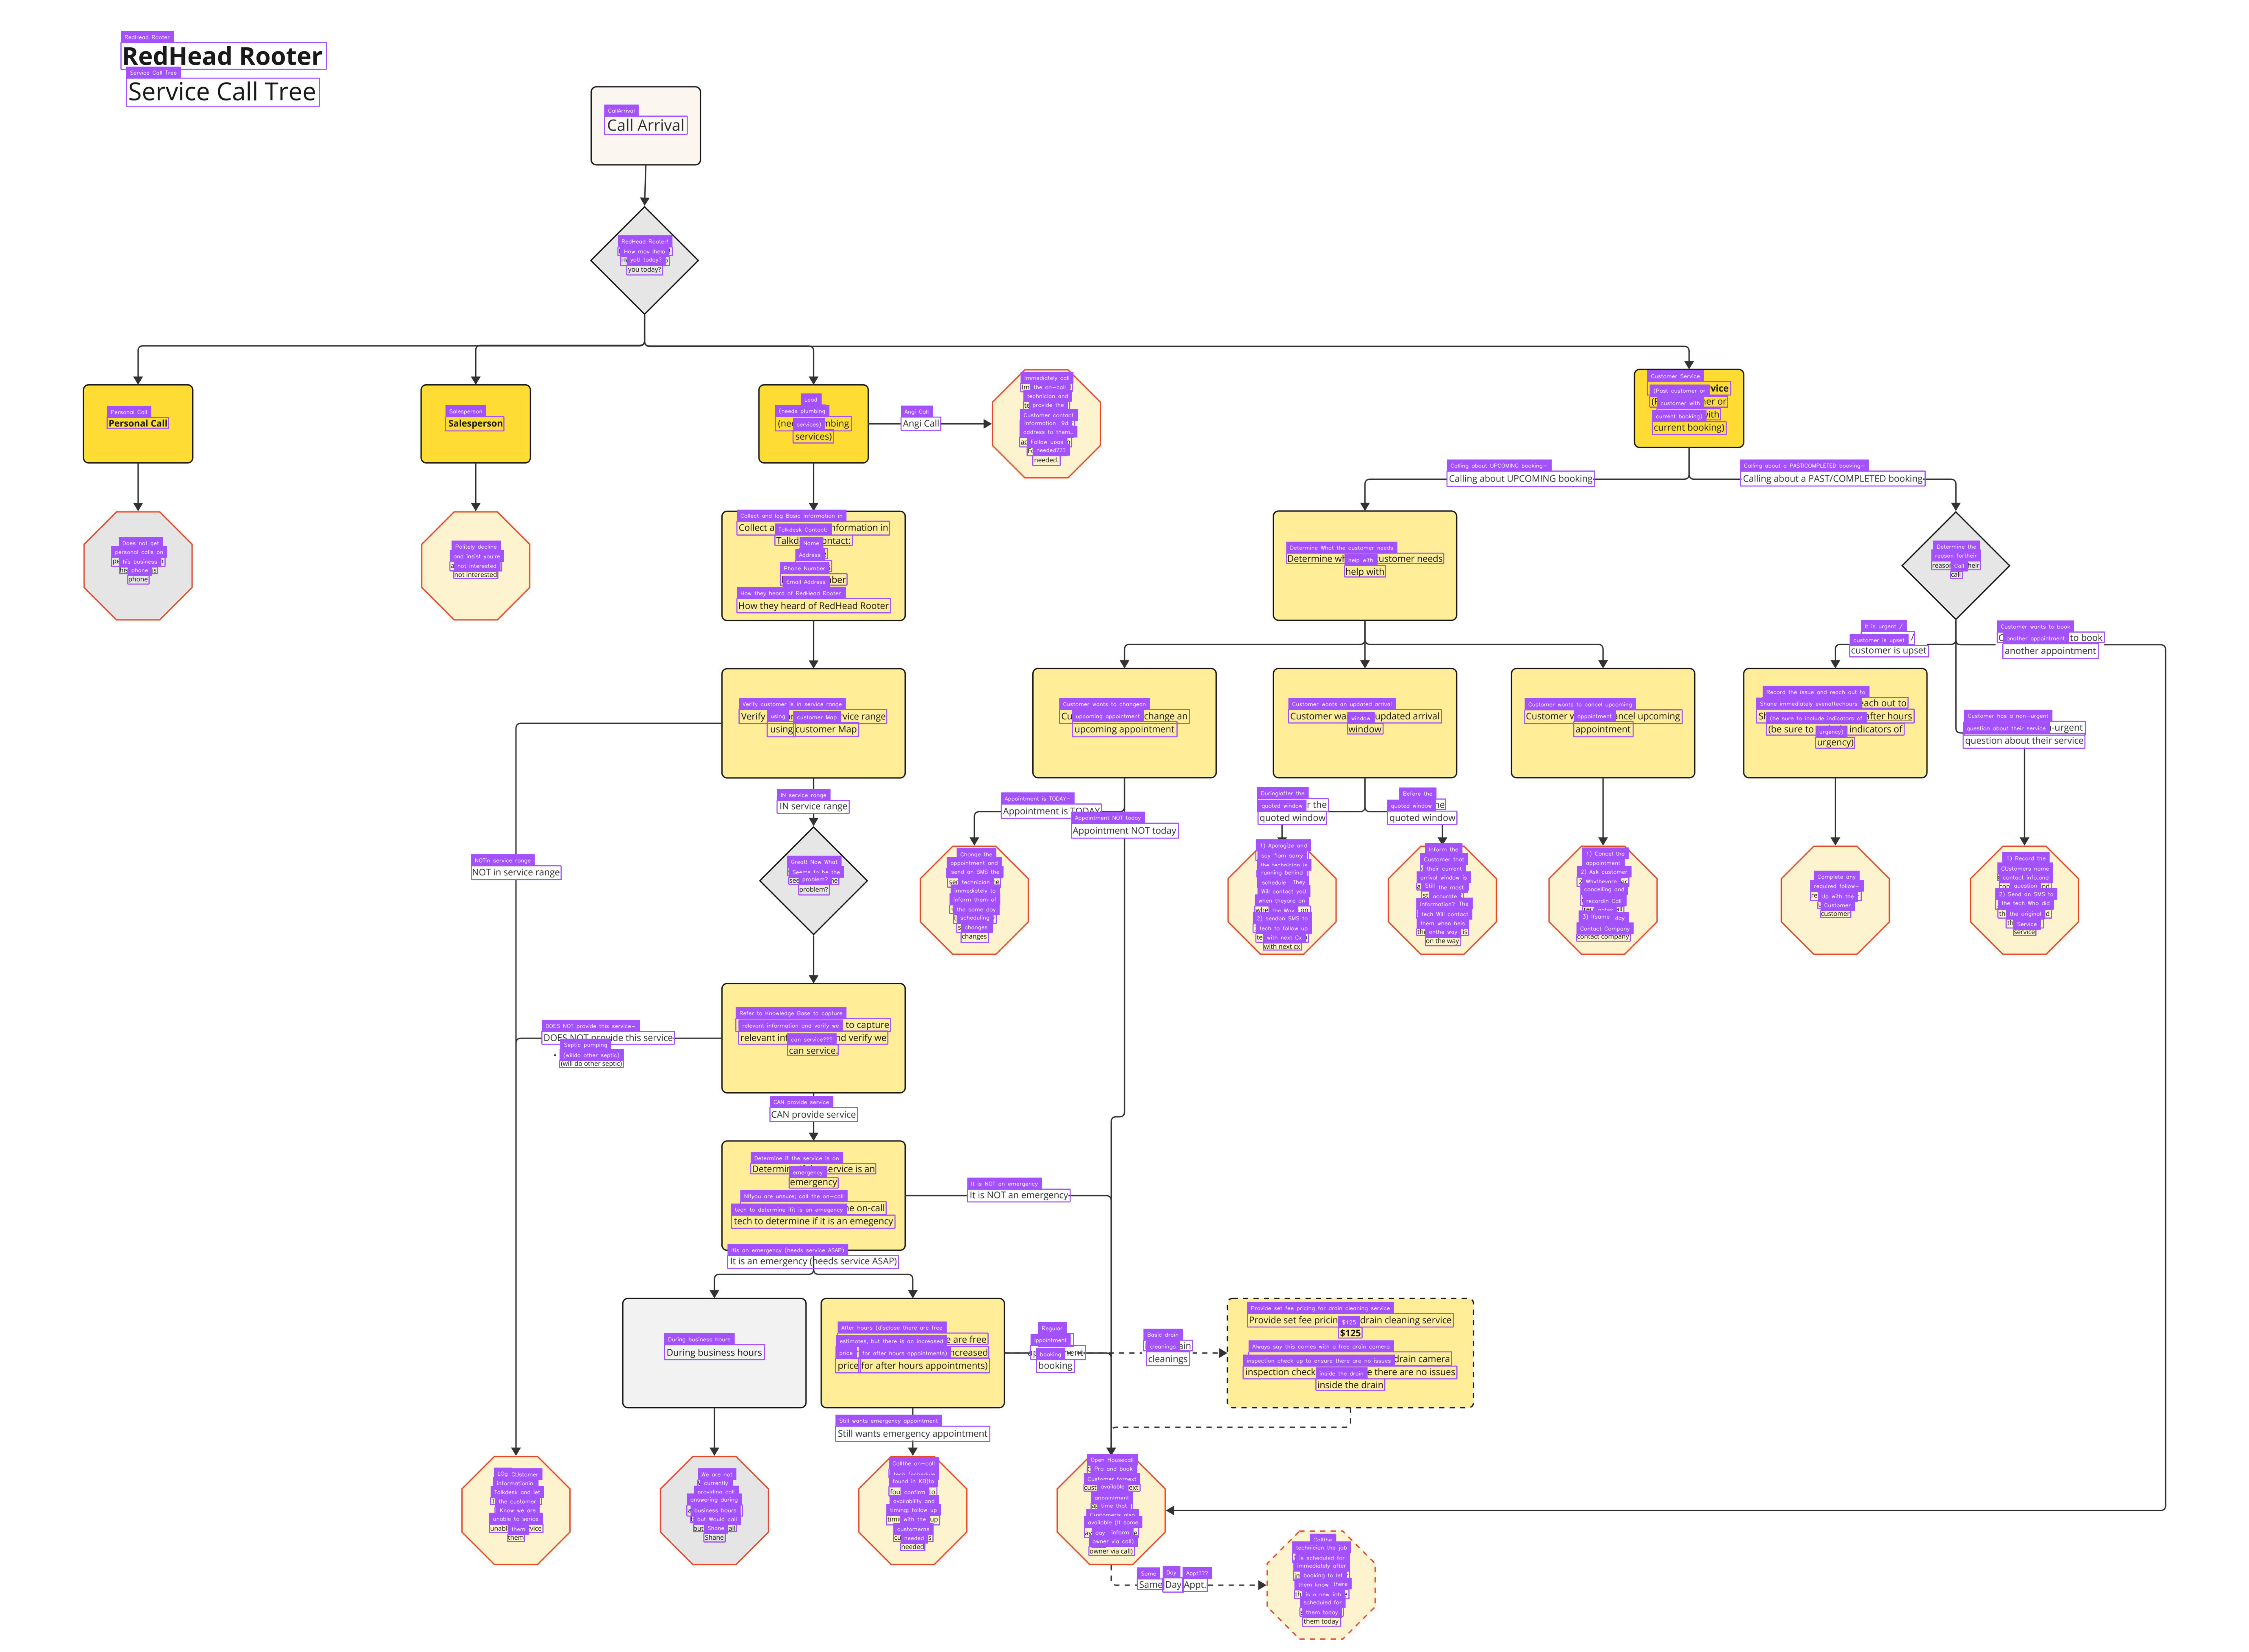

True

In [6]:
import supervision as sv
import cv2
import numpy as np

image = cv2.imread('/kaggle/working/imgs/RedHead Rooter Service Call Tree-1.jpeg')

xyxy, confidences, class_ids, label = [], [], [], []

# Extract data from OCR result
for detection in verbose_nodes:
    bbox, text, confidence = detection[0], detection[1], detection[2]
   
    # Convert bounding box format
    x_min = int(min([point[0] for point in bbox]))
    y_min = int(min([point[1] for point in bbox]))
    x_max = int(max([point[0] for point in bbox]))
    y_max = int(max([point[1] for point in bbox]))
   
    # Append data to lists
    xyxy.append([x_min, y_min, x_max, y_max])
    label.append(text)
    confidences.append(confidence)
    class_ids.append(0)  

# Convert to NumPy arrays
detections = sv.Detections(
    xyxy=np.array(xyxy),
    confidence=np.array(confidences),
    class_id=np.array(class_ids)
)

# Annotate image with bounding boxes and labels
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=label)

# Display and save the annotated image
sv.plot_image(image=annotated_image, size=[100, 100])
cv2.imwrite("/kaggle/working/Output.jpg", annotated_image)

## GET NODES FOR PROMPT

In [3]:
import easyocr
reader = easyocr.Reader(['ch_sim','en'], )
nodes = reader.readtext('/kaggle/working/imgs/RedHead Rooter Service Call Tree-1.jpeg',
                        detail = 0, paragraph=True,
                        canvas_size=5000,
                        decoder="wordbeamsearch",
                        ## experiment below. Ref: https://www.jaided.ai/easyocr/documentation/
                        beamWidth = 10,
                        width_ths=0.9, 
                        # height_ths=1.2,
                        text_threshold=0.6,
                        # x_ths=1,
                        # y_ths=1.9,
                        # ycenter_ths=0.7,
                        # mag_ratio=1.5,
                        )
nodes

Progress: |██████████████████████████████████████████████████| 100.0% Complete

['RedHead Rooter Service Call Tree',
 'CallArrival',
 'RedHead Rooter! How may Ihelp yoU today?',
 'Immediately call the on-call technician and provide the Customer contact information 9d address to them_ Follow Upas needed。',
 'Customer Service (Past customer or customer with current booking)',
 'Lead',
 'Personal Call',
 'Salesperson',
 '(needs plumbing services)',
 'Angi Call',
 'Calling about UPCOMING booking-',
 'Calling about a PASTICOMPLETED booking-',
 'Collect and log Basic Information in Talkdesk Contact: Name Address Phone Number Email Address How they heard of RedHead Rooter',
 'Does not get personal calls on his business phone',
 "Politely decline and insist you're not interested",
 'Determine the reason fortheir Call',
 'Determine What the customer needs help with',
 'It is urgent / customeris upset',
 'Customer wants to book another appointment',
 'Record the issue and reach out to Shane immediately evenaftechours (be sure to include indicators of urgency)',
 'Verify cus

### LINEARIZE DIAGRAM

In [16]:
import os
os.environ["ANTHROPIC_API_KEY"] = "yyy"
os.environ['OPENAI_API_KEY'] = "jjj"
import anthropic
import base64
from textwrap import dedent

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


image_path = "/kaggle/working/imgs/RedHead Rooter Service Call Tree-1.jpeg"
base64_image = encode_image(image_path)

client = anthropic.Anthropic()

prompt = """The workflow in the provided image is a process diagram that describes steps or nodes that an customer service human agent handles phone calls from a person in different cases.
Based on the example above, your task is to interpret the diagram and generate all various relationships found in it.
Each box means a node.
### Strictly comply with the following rules:
- In the output, include all boxes and texts found in the diagram, and keep the texts as they are. Expand texts are they are in the original diagram.
- In the output, each Step corresponds with a box of any shape (rectangle, haxagon or diamond). Include all the nodes until you find no more.
- For a current decision step that leads to multiple possible steps, use if-clauses in the current step to show steps that may conditionally come next. This is crucial for your success.
- In the If-clause or in every Step, always use "go to Step <step_id>" as the reference to the next step. This is extremely important.
These are extremely important requirements you must follow.

The following elements are nodes or conditions in the diagram. You have to consider them all together with the diagram when creating the output. Ensure to use all the elements in your output because they're the essential nodes and conditions.
### Elements to consider:
{nodes}

Here is an example illustrating the output template:
**Step 3: Lead**: The caller needs plumbing services.
    Step 3.1: Take these substeps in order
        1. Ask the customer back about their basic information if it's not available initially: Name, Address, Phone Number and Email Address.
        2. Next, log the information in Talkdesk Contact. 
        3. Then go to Step 3.2
    Step 3.2: Verify customer is in service range using customer Map. 
        If customer is not in service range, go to Step 3.3, else go to Step 3.4              
    Step 3.3:
        - Log customer information in Talkdesk Contact
        - Let the customer know we are unable to service them
        - End the call
    Step 3.4: ...
""".format(nodes=nodes)

message = client.messages.create(
    model="claude-3-5-sonnet-20241022",
    temperature=0.1,
    max_tokens=4024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": base64_image,
                    },
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ],
        }
    ],
)

diagram_text = message.content[0].text
print(diagram_text)

I'll help create a structured workflow based on the service call tree diagram. Here's the complete interpretation:

**Step 1: Call Arrival**
When a call arrives, determine the type of call. Based on the type:
- If it's a Personal Call, go to Step 2
- If it's a Salesperson, go to Step 3
- If it's a Lead (needs plumbing services), go to Step 4
- If it's Customer Service (Past customer or customer with current booking), go to Step 5

**Step 2: Personal Call**
- Does not get personal calls on his business phone
- End call

**Step 3: Salesperson**
- Politely decline and insist you're not interested
- End call

**Step 4: Lead (needs plumbing services)**
Step 4.1: Collect and log Basic Information in Talkdesk Contact:
- Name
- Address
- Phone Number
- Email Address
- How they heard of RedHead Rooter
Then go to Step 4.2

Step 4.2: Verify customer is in service range using customer Map
If NOT in service range, go to Step 4.3
If IN service range, go to Step 4.4

Step 4.3: 
- Log customer informa

In [17]:
reflect_prompt = dedent("""
The following text is a way to describe the nodes and their relationships in the diagram from the provided image.
<text>
{diagram_text}
</text>

Here are a list of elements that an ideal text for the diagram should include:
<elements>
{elements}
</elements>

Your task to is meticulously comparing the text against each element of the element list to see if the text misses any elements. If it does, add those elements to the text, using the diagram as a reference.
You should return:
- All elements that were not mentioned in the text.
- A complete revised diagram text with these elements seamlessly incorporated into the appropriate sections. 
The new text must be complete and contain no notes so that when you read it, you won't know that modifications are there. Add title "### Revised text" before the text.
""").strip().format(diagram_text=diagram_text, elements=nodes)
reflect_message = client.messages.create(
    model="claude-3-5-sonnet-20241022",
    temperature=0.3,
    max_tokens=4024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": base64_image,
                    },
                },
                {
                    "type": "text",
                    "text": reflect_prompt
                }
            ],
        }
    ],
)

reflect = reflect_message.content[0].text
print(reflect)

After comparing the text with the elements list, I found these missing elements:
1. "RedHead Rooter! How may I help you today?" - Initial greeting
2. "Angi Call" - A type of lead call
3. "Great! Now What Seems to be the problem?" - Follow-up question after collecting information
4. "Complete any required follow-up with the customer"
5. "Basic drain cleanings" - Specification for regular appointment booking
6. "Open Housecall Pro and book Customer for next available appointment time that Customer is also available (If same day inform owner via call)" - Specific booking procedure
7. "Call the technician the job is scheduled for immediately after booking to let them know there is a new job scheduled for them today" - Follow-up procedure for same-day appointments

### Revised text
**Step 1: Call Arrival**
Start with greeting: "RedHead Rooter! How may I help you today?"
When a call arrives, determine the type of call. Based on the type:
- If it's a Personal Call, go to Step 2
- If it's a Sa

In [18]:
def extract_result(text: str) -> str:
    if "### Revised text" in text:
        revised_text = text.split("### Revised text", 1)[1].strip()
    else:
        revised_text = None 
    return revised_text
print(extract_result(reflect))

**Step 1: Call Arrival**
Start with greeting: "RedHead Rooter! How may I help you today?"
When a call arrives, determine the type of call. Based on the type:
- If it's a Personal Call, go to Step 2
- If it's a Salesperson, go to Step 3
- If it's a Lead (needs plumbing services or Angi Call), go to Step 4
- If it's Customer Service (Past customer or customer with current booking), go to Step 5

**Step 2: Personal Call**
- Does not get personal calls on his business phone
- End call

**Step 3: Salesperson**
- Politely decline and insist you're not interested
- End call

**Step 4: Lead (needs plumbing services)**
Step 4.1: Collect and log Basic Information in Talkdesk Contact:
- Name
- Address
- Phone Number
- Email Address
- How they heard of RedHead Rooter
Then ask: "Great! Now what seems to be the problem?"
Then go to Step 4.2

Step 4.2: Verify customer is in service range using customer Map
If NOT in service range, go to Step 4.3
If IN service range, go to Step 4.4

Step 4.3: 
- Log c